## Making the study area

To employ the internal Rossby radius of deformation to limit the study area, I have decided to try the following:
- Make a polygon around the wind park by finding minimum and maximum of lon/lat in the coordinates.
- Then add X times the Rossby radius in all directions. Choice of X depends on what it looks like. I want to make X big enough such that the wind wake is within.
- I will choose the mean Rossby radius of June to be the value 'to add on'. This is because I would like to make sure that the largest eddies are also seen. 
- Below I'm testing this approach on Sørvest-F and Nordvest-C to see if the method works and looks reasonable.

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import numpy as np
import xarray as xr
import cartopy 
from datetime import datetime, timedelta
import pandas as pd
from Rossby_deformation.get_turbine_coords import get_turbine_coords
from netCDF4 import Dataset
from roppy import SGrid
import xroms
from cartopy import config
from glob import glob
from Rossby_deformation.funcs import *

%load_ext autoreload
%autoreload 2

In [2]:
# Opening a file to retrieve the grid
fid = Dataset('/lustre/storeB/project/nwp/havvind/hav/results/reference/REF-02/norkyst_avg_0001.nc')
grid = SGrid(fid)
del fid

In [3]:
# Opening the turbine coordinates as a xArray DataSet
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')

In [4]:
nordvest_C = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Nordvest_C.txt')

In [5]:
# Extracting paths to files containing the computed Rossby deformation radius
# Note: I'm using the reference datasets and not the experiments
# Rossby deformation radius computed from the experiment datasets are found in output_bdr/EXP

filefolder = glob('/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/REF')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_brr.nc'
        files.append(filefolder[0]+file_path)

In [6]:
# Longitudes and latitudes of the grid
lon = grid.lon_rho
lat = grid.lat_rho

In [7]:
# Square around wind park
min_lon_SV = np.min(sorvest_F.coordinates[:,0].values)
min_lat_SV = np.min(sorvest_F.coordinates[:,1].values)
max_lon_SV = np.max(sorvest_F.coordinates[:,0].values)
max_lat_SV = np.max(sorvest_F.coordinates[:,1].values)

area_lon_SV = [min_lon_SV, max_lon_SV]
area_lat_SV = [min_lat_SV, max_lat_SV]

In [8]:
min_lon_NV = np.min(nordvest_C.coordinates[:,0].values)
min_lat_NV = np.min(nordvest_C.coordinates[:,1].values)
max_lon_NV = np.max(nordvest_C.coordinates[:,0].values)
max_lat_NV = np.max(nordvest_C.coordinates[:,1].values)

area_lon_NV = [min_lon_NV, max_lon_NV]
area_lat_NV = [min_lat_NV, max_lat_NV]

In [9]:
# Getting the monthly mean of R1 of the area
# The mean of June will be the distance added to expand to study area
R1_mon_mean_SV = monthly_mean_area(files, grid, area_lon_SV, area_lat_SV)
R1_mon_mean_NV = monthly_mean_area(files, grid, area_lon_NV, area_lat_NV)

In [10]:
ds_SV = new_make_study_area(files, grid, area_lon_SV, area_lat_SV, R1_mon_mean_SV[-1])

In [11]:
ds_NV = new_make_study_area(files, grid, area_lon_NV, area_lat_NV, R1_mon_mean_NV[-1])

In [12]:
ds_monthly = monthly_mean(files)

Text(0.5, 0.98, 'Study area - Sørvest-F')

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:538: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


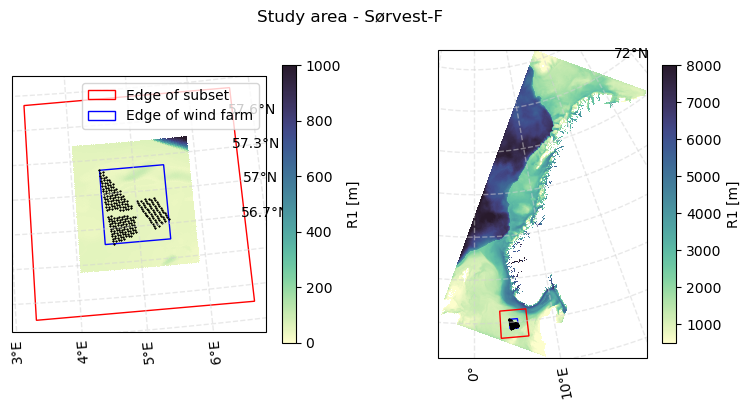

In [13]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw={'projection':proj})

cmap = 'cmo.deep'

pll = ax[0].pcolormesh(ds_SV.lon_rho, ds_SV.lat_rho, ds_SV.gamma_r[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

pl = ax[1].pcolormesh(lon, lat, ds_monthly.gamma_r[-1,:,:], transform=ccrs.PlateCarree(), cmap=cmap, vmin=500, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

area_lon = [np.min(ds_SV.lon_rho), np.max(ds_SV.lon_rho), np.max(ds_SV.lon_rho), np.min(ds_SV.lon_rho)]
area_lat = [np.min(ds_SV.lat_rho), np.min(ds_SV.lat_rho), np.max(ds_SV.lat_rho), np.max(ds_SV.lat_rho)]

ax[0].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1, label='Edge of subset')
ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

w_lon = [np.min(sorvest_F.coordinates[:, 0]), np.max(sorvest_F.coordinates[:, 0]), 
         np.max(sorvest_F.coordinates[:, 0]), np.min(sorvest_F.coordinates[:, 0])]
w_lat = [np.min(sorvest_F.coordinates[:, 1]), np.min(sorvest_F.coordinates[:, 1]), 
         np.max(sorvest_F.coordinates[:, 1]), np.max(sorvest_F.coordinates[:, 1])]

ax[0].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1, label='Edge of wind farm')
ax[1].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1)

for axs in ax:
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

ax[0].legend()

fig.suptitle('Study area - Sørvest-F')

Text(0.5, 0.98, 'Study area - Nordvest - C')

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:538: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


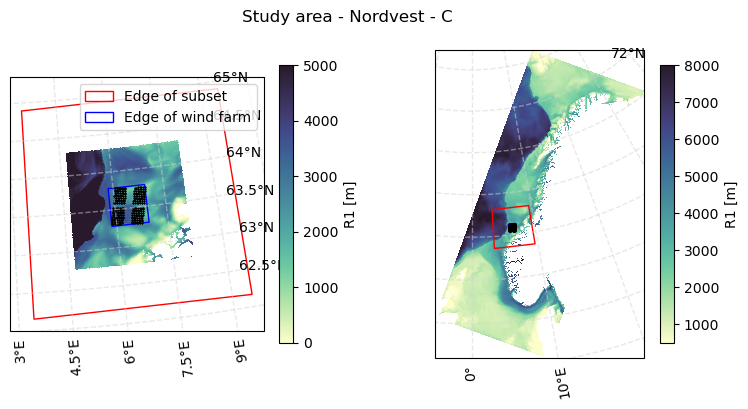

In [14]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw={'projection':proj})

cmap = 'cmo.deep'

pll = ax[0].pcolormesh(ds_NV.lon_rho, ds_NV.lat_rho, ds_NV.gamma_r[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=5000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

pl = ax[1].pcolormesh(lon, lat, ds_monthly.gamma_r[-1,:,:], transform=ccrs.PlateCarree(), cmap=cmap, vmin=500, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

area_lon = [np.min(ds_NV.lon_rho), np.max(ds_NV.lon_rho), np.max(ds_NV.lon_rho), np.min(ds_NV.lon_rho)]
area_lat = [np.min(ds_NV.lat_rho), np.min(ds_NV.lat_rho), np.max(ds_NV.lat_rho), np.max(ds_NV.lat_rho)]

ax[0].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1, label='Edge of subset')
ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

w_lon = [np.min(nordvest_C.coordinates[:, 0]), np.max(nordvest_C.coordinates[:, 0]), 
         
         np.max(nordvest_C.coordinates[:, 0]), np.min(nordvest_C.coordinates[:, 0])]
w_lat = [np.min(nordvest_C.coordinates[:, 1]), np.min(nordvest_C.coordinates[:, 1]), 
         np.max(nordvest_C.coordinates[:, 1]), np.max(nordvest_C.coordinates[:, 1])]

ax[0].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1, label='Edge of wind farm')
ax[1].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1)

for axs in ax:
    for i in range(len(nordvest_C.coordinates)):
        axs.plot(nordvest_C.coordinates[i][0], nordvest_C.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

ax[0].legend()

fig.suptitle('Study area - Nordvest - C')

In [15]:
path = '/lustre/storeB/project/nwp/havvind/hav/results/reference/REF-02/norkyst_avg_0001.nc'
data = xr.open_dataset(path)

In [16]:
data.angle

<xarray.DataArray 'angle' (eta_rho: 1148, xi_rho: 2747)>
[3153556 values with dtype=float64]
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 ...
    lat_rho  (eta_rho, xi_rho) float64 ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  angle between XI-axis and EAST
    units:      radians
    grid:       grid
    location:   face
    field:      angle, scalar

In [17]:
R1_mon_mean_SV[-1].values

array(1677.00945145)

In [18]:
test_area = make_study_area(files, grid, area_lon_SV, area_lat_SV, R1_mon_mean_SV[-1].values)

Text(0.5, 0.98, 'Study area - Sørvest-F')

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:538: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


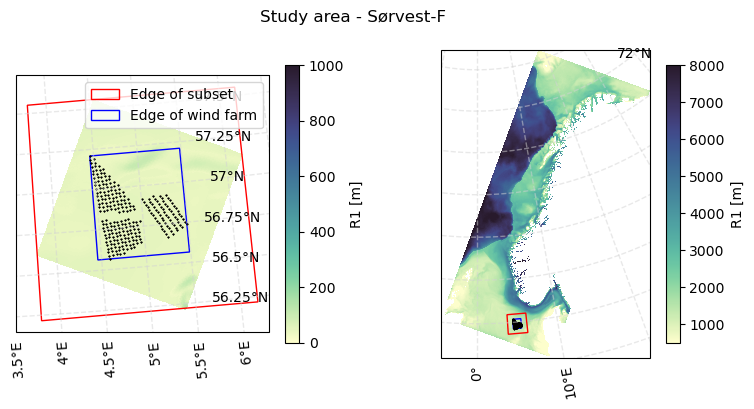

In [19]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw={'projection':proj})

cmap = 'cmo.deep'

pll = ax[0].pcolormesh(test_area.lon_rho, test_area.lat_rho, test_area.gamma_r[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

pl = ax[1].pcolormesh(lon, lat, ds_monthly.gamma_r[-1,:,:], transform=ccrs.PlateCarree(), cmap=cmap, vmin=500, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

area_lon = [np.min(test_area.lon_rho), np.max(test_area.lon_rho), np.max(test_area.lon_rho), np.min(test_area.lon_rho)]
area_lat = [np.min(test_area.lat_rho), np.min(test_area.lat_rho), np.max(test_area.lat_rho), np.max(test_area.lat_rho)]

ax[0].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1, label='Edge of subset')
ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

w_lon = [np.min(sorvest_F.coordinates[:, 0]), np.max(sorvest_F.coordinates[:, 0]), 
         np.max(sorvest_F.coordinates[:, 0]), np.min(sorvest_F.coordinates[:, 0])]
w_lat = [np.min(sorvest_F.coordinates[:, 1]), np.min(sorvest_F.coordinates[:, 1]), 
         np.max(sorvest_F.coordinates[:, 1]), np.max(sorvest_F.coordinates[:, 1])]

ax[0].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1, label='Edge of wind farm')
ax[1].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1)

for axs in ax:
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

ax[0].legend()

fig.suptitle('Study area - Sørvest-F')

In [20]:
testt = test_make_a_region(files, grid, area_lon_SV, area_lat_SV, R1_mon_mean_SV[-1].values)

Text(0.5, 0.98, 'Study area - Sørvest-F')

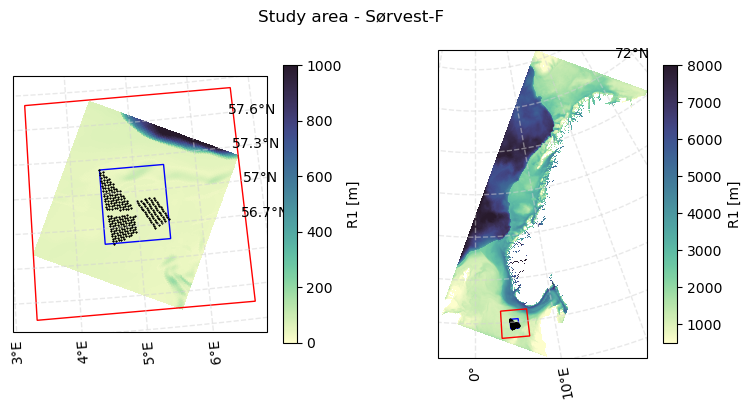

In [21]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw={'projection':proj})

cmap = 'cmo.deep'

pll = ax[0].pcolormesh(testt.lon_rho, testt.lat_rho, testt.gamma_r[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

pl = ax[1].pcolormesh(lon, lat, ds_monthly.gamma_r[-1,:,:], transform=ccrs.PlateCarree(), cmap=cmap, vmin=500, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

area_lon = [np.min(testt.lon_rho), np.max(testt.lon_rho), np.max(testt.lon_rho), np.min(testt.lon_rho)]
area_lat = [np.min(testt.lat_rho), np.min(testt.lat_rho), np.max(testt.lat_rho), np.max(testt.lat_rho)]

ax[0].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)
ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

w_lon = [np.min(sorvest_F.coordinates[:, 0]), np.max(sorvest_F.coordinates[:, 0]), 
         np.max(sorvest_F.coordinates[:, 0]), np.min(sorvest_F.coordinates[:, 0])]
w_lat = [np.min(sorvest_F.coordinates[:, 1]), np.min(sorvest_F.coordinates[:, 1]), 
         np.max(sorvest_F.coordinates[:, 1]), np.max(sorvest_F.coordinates[:, 1])]

ax[0].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1)
ax[1].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1)

for axs in ax:
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

fig.suptitle('Study area - Sørvest-F')